# QNN for VLDS Dataset 10k
## Prepare data

In [1]:
import concurrent
import multiprocessing
import time
from qiskit import IBMQ
import pandas as pd
import numpy as np
from IPython.core.display_functions import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, ADAM, SLSQP
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, TwoLocal, PauliFeatureMap
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


## Provide configuration options for the learning process
---

In [2]:
RANDOM_SEED = 42
SHOTS = 1024
TRAIN_DATA_SPLIT = 0.75
FOLDS = 10

## Prepare and analyze dataset
---

In [3]:
df = pd.read_csv('datasets/vlds_10k.csv', index_col=0)
df.count()

feature_1    10000
feature_2    10000
feature_3    10000
feature_4    10000
label        10000
dtype: int64

In [4]:
display(df)

,feature_1,feature_2,feature_3,feature_4,label
0,10.0,5.0,3.0,24.0,1.0
1,12.0,2.0,11.0,26.0,1.0
2,10.0,3.0,3.0,30.0,1.0
3,9.0,10.0,14.0,17.0,0.0
4,15.0,2.0,11.0,28.0,1.0
...,...,...,...,...,...
9995,17.0,0.0,9.0,28.0,1.0
9996,11.0,1.0,10.0,31.0,1.0
9997,5.0,1.0,11.0,21.0,1.0
9998,15.0,2.0,9.0,23.0,1.0


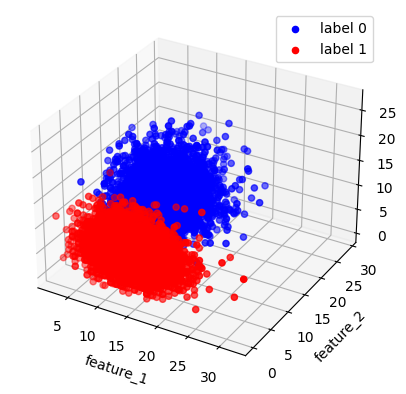

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# separate the dataframe into different dataframe based on label column
df_0 = df[df['label'] == 0.0]
df_1 = df[df['label'] == 1.0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_0['feature_1'], df_0['feature_2'], df_0['feature_3'], c='blue', label='label 0')
ax.scatter(df_1['feature_1'], df_1['feature_2'], df_1['feature_3'], c='red', label='label 1')
ax.set_xlabel('feature_1')
ax.set_ylabel('feature_2')
ax.set_zlabel('feature_3')
plt.legend()
plt.show()

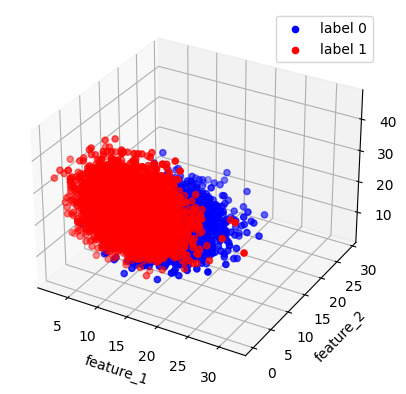

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_0['feature_1'], df_0['feature_2'], df_0['feature_4'], c='blue', label='label 0')
ax.scatter(df_1['feature_1'], df_1['feature_2'], df_1['feature_4'], c='red', label='label 1')
ax.set_xlabel('feature_1')
ax.set_ylabel('feature_2')
ax.set_zlabel('feature_4')
plt.legend()
plt.show()

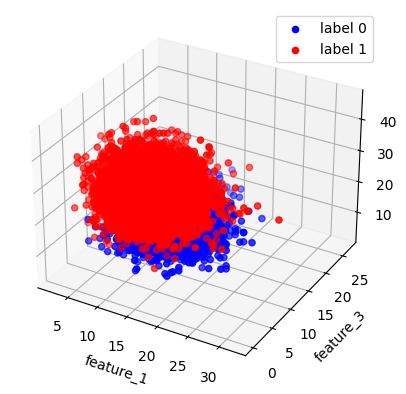

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_0['feature_1'], df_0['feature_3'], df_0['feature_4'], c='blue', label='label 0')
ax.scatter(df_1['feature_1'], df_1['feature_3'], df_1['feature_4'], c='red', label='label 1')
ax.set_xlabel('feature_1')
ax.set_ylabel('feature_3')
ax.set_zlabel('feature_4')
plt.legend()
plt.show()

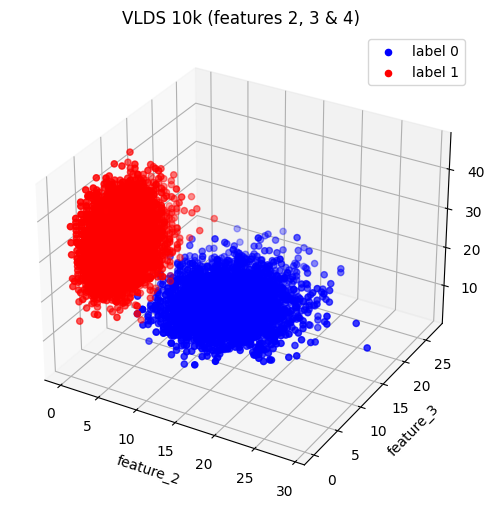

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_0['feature_2'], df_0['feature_3'], df_0['feature_4'], c='blue', label='label 0')
ax.scatter(df_1['feature_2'], df_1['feature_3'], df_1['feature_4'], c='red', label='label 1')
ax.set_xlabel('feature_2')
ax.set_ylabel('feature_3')
ax.set_zlabel('feature_4')
plt.title('VLDS 10k (features 2, 3 & 4)')
plt.legend()
plt.show()

In [5]:
print(f'Rows with label = 1: #{df.where(df["label"] == 1.0)["label"].count()}')
print(f'Rows with label = 0: #{df.where(df["label"] == 0.0)["label"].count()}')

feature_dimension = df.shape[1] - 1
print(f"Feature dimension: {feature_dimension}")

Rows with label = 1: #6648
Rows with label = 0: #3352
Feature dimension: 4


In [6]:
# Split the data into training and test sets
all_features = df.copy()
all_labels = all_features.pop('label')

train = df.sample(frac=TRAIN_DATA_SPLIT, random_state=RANDOM_SEED)
test = df.drop(train.index)

# Separate the features from the labels
train_features = train.copy()
test_features = test.copy()

train_labels = train_features.pop('label')
test_labels = test_features.pop('label')

## Setup quantum circuit
---

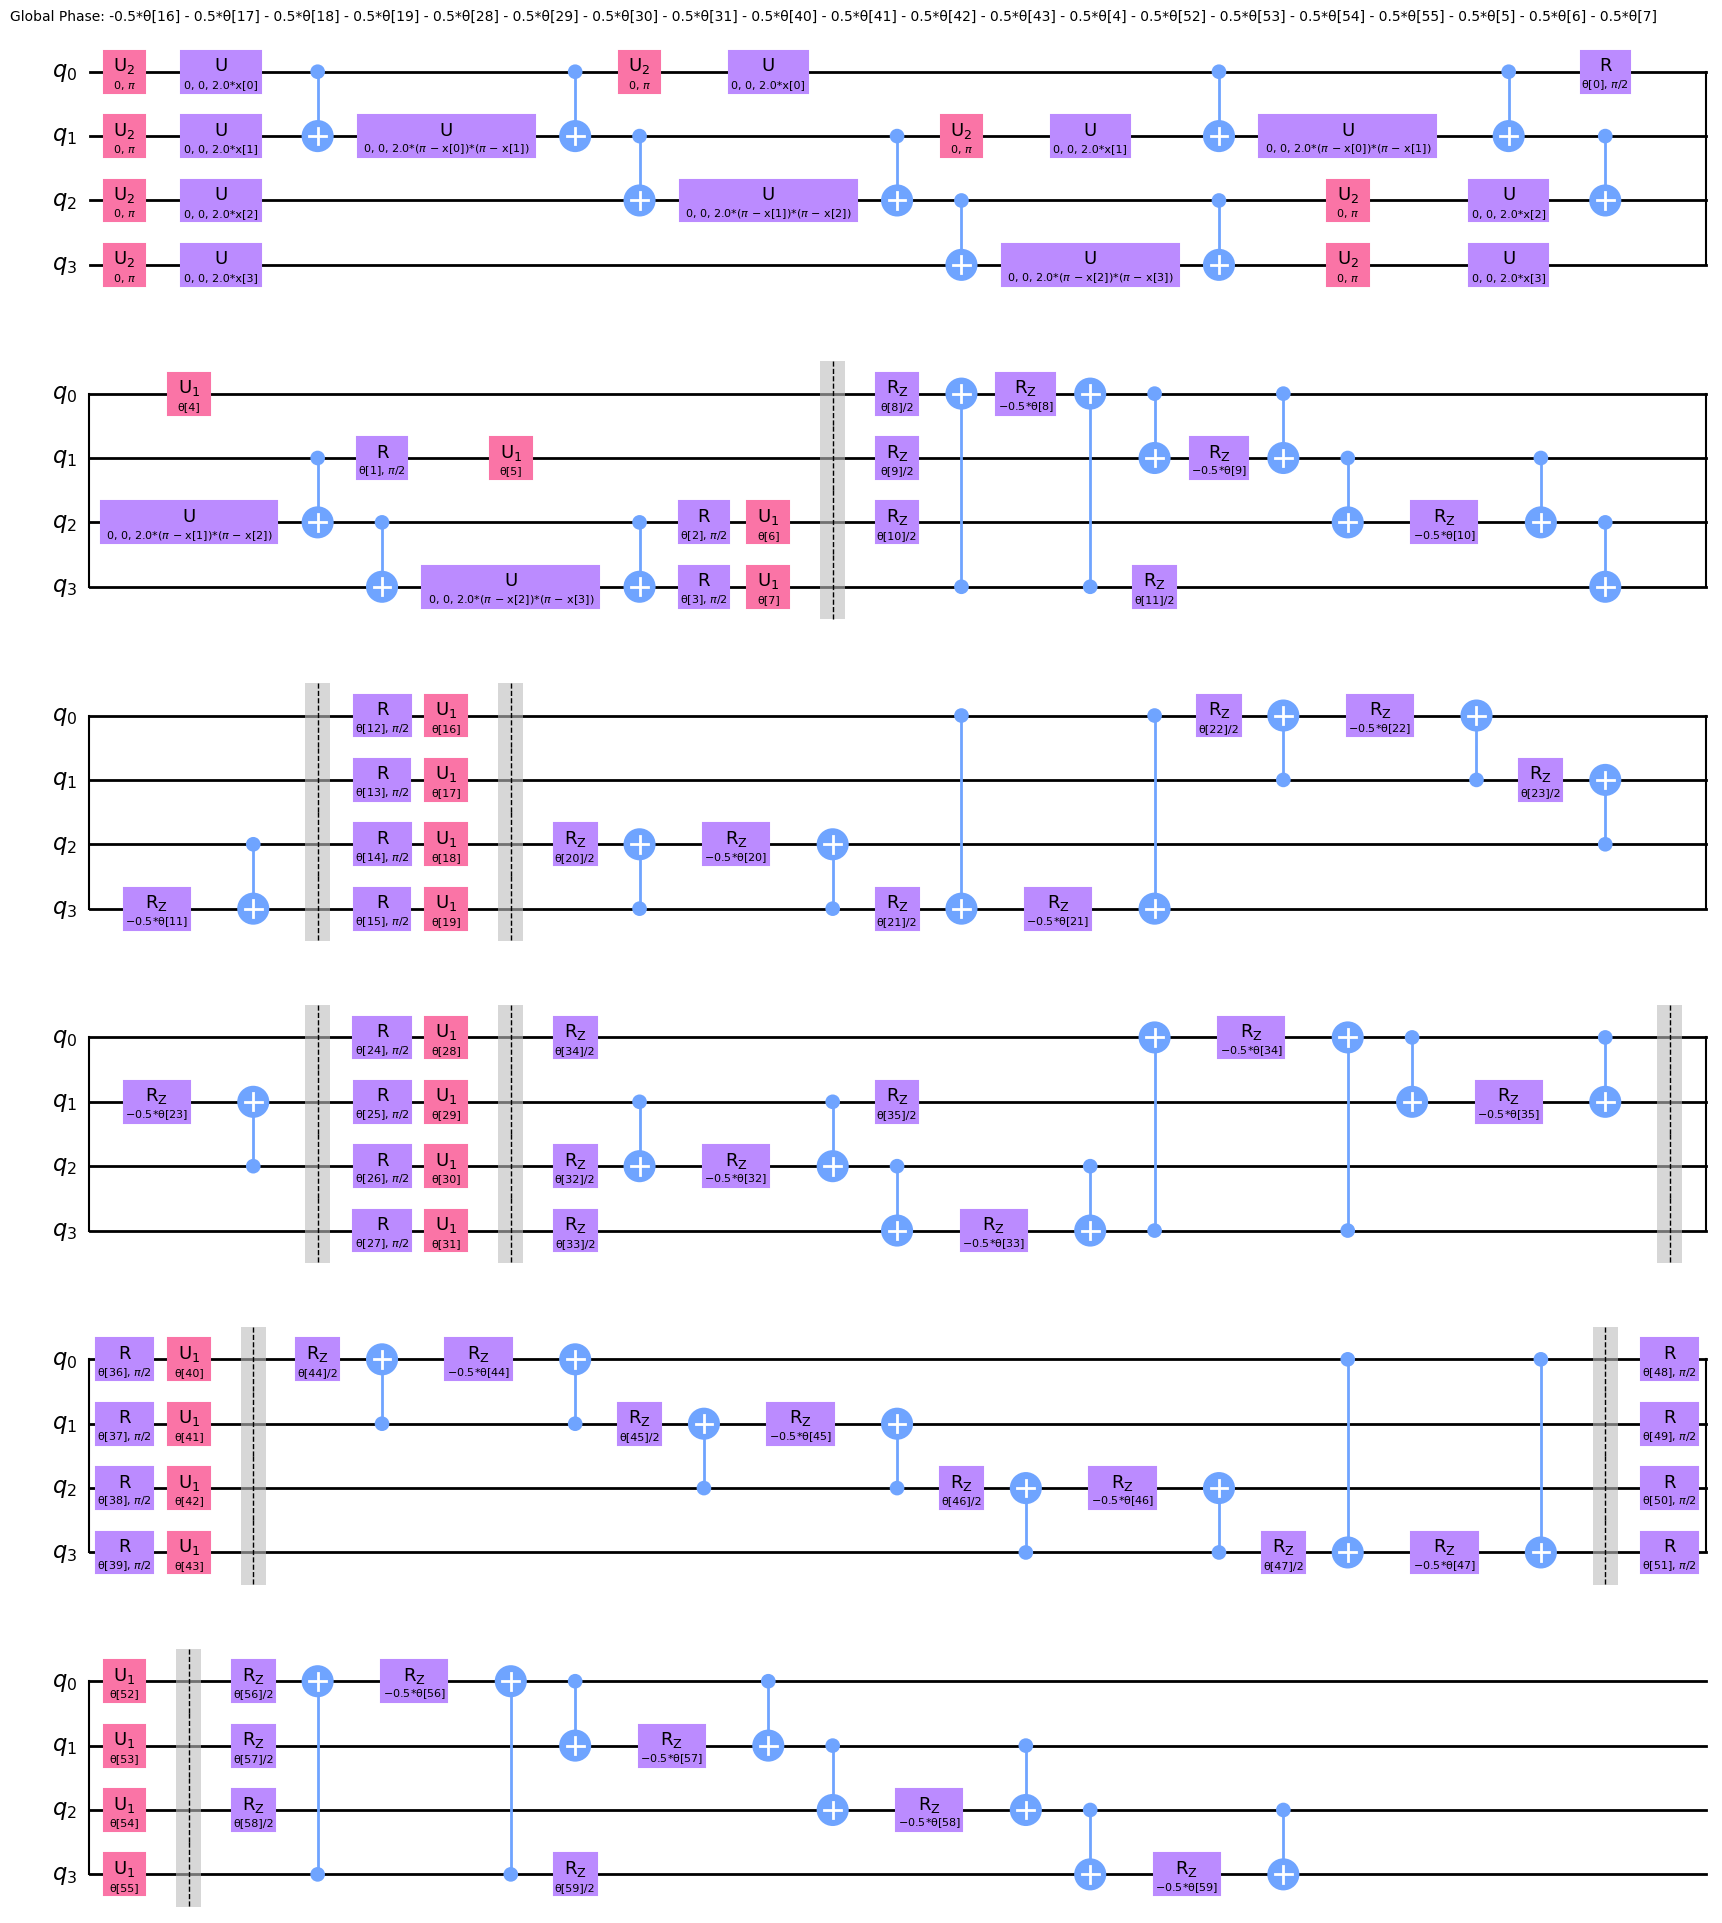

In [7]:
algorithm_globals.random_seed = RANDOM_SEED
quantum_instance = QuantumInstance(Aer.get_backend("qasm_simulator"), shots=SHOTS)

feature_map = ZZFeatureMap(feature_dimension=feature_dimension, entanglement='linear')
# feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=5, paulis=['Z', 'XX'])
# ansatz = RealAmplitudes(num_qubits=feature_map.num_qubits, insert_barriers=True, reps=5)
# ansatz = TwoLocal(num_qubits=feature_map.num_qubits,  reps=5, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', insert_barriers=True, skip_final_rotation_layer=False)
ansatz = TwoLocal(num_qubits=feature_map.num_qubits,  reps=5, rotation_blocks=['ry', 'rz'], entanglement_blocks='crz', entanglement= 'sca', insert_barriers=True, skip_final_rotation_layer=True)
qc = QuantumCircuit(ansatz.num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.decompose().decompose().draw(output='mpl')

In [8]:
def parity(x):
    # return "{:b}".format(x)[0] == '1'
    return "{:b}".format(x).count("1") % 2


sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    output_shape=2 ** qc.num_qubits,
    interpret=parity,
)

In [9]:
objective_func_vals = []

def callback_print(_weights, obj_func_eval):
    #clear_output(wait=True)
    #objective_func_vals.append(obj_func_eval)
    print(obj_func_eval)

models = [
    NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    optimizer=COBYLA(maxiter=100),
    # optimizer=ADAM(maxiter=500),
    # optimizer=SLSQP(maxiter=250),
    callback=callback_print
    ) for fold in range(FOLDS)
]

futures = []
training_times = []

# Train the model
k_fold = KFold(n_splits=FOLDS)
with concurrent.futures.ThreadPoolExecutor() as executor:
    for i, (train_index, test_index) in enumerate(k_fold.split(train_features)):
        model = models[i]
        current_start = time.time()
        current_train_features = train_features.iloc[train_index].to_numpy()
        current_train_labels = train_labels.iloc[train_index].to_numpy()
        futures.append(executor.submit(model.fit,current_train_features, current_train_labels.astype("int")))
        futures[i].add_done_callback(lambda _: training_times.append(time.time() - current_start))
    executor.shutdown(wait=True)
    models = [future.result() for future in futures]




0.5038067966767824
0.504435280976061
0.5053978105812047
0.5041269714767765
0.5036247186931854
0.5025905729735938
0.5007467653511368
0.5012111468604408
0.5007977912744521
0.49838715376060283
0.5007433977301314
0.49697649080900613
0.4971687065337775
0.4959236496243697
0.4989290694822313
0.49727610557694857
0.4981069570010009


In [ ]:
scores = []

for model in models:
    scores.append(model.score(test_features, test_labels))

time_splits = []

for idx, time in enumerate(training_times):
    if (idx == 0): time_splits.append(training_times[idx])
    else :
        time_splits.append(training_times[idx] - training_times[idx-1])

print(f"Scores: {scores}")
print(f'Times: {time_splits}')
print(f'Average Training Time: {np.array(time_splits).mean()}')


Accuracy: 0.58
